In [1]:
#  Итоговый проект. Создание и оптимизация рекуррентной нейросети. By A. Khodorov
# Выполнено на облачном сервере Reg.ru
# ОЗУ - 4Гб, Python - 3.10, tensorflow - 2.15 (12.12.23)

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import tensorflow as tf
from keras import layers, models

# Шаг 1. Загружаем данные и создаём DataFrame

# Тренировочный датасет MNIST с соревнования Kaggle

train_mnist_K = pd.read_csv('data/train.csv')
print('Тренировочный датасет MNIST с соревнования Kaggle: ', train_mnist_K.shape)
print(train_mnist_K)

2023-12-13 01:47:10.154214: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 01:47:10.712087: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-13 01:47:10.712229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-13 01:47:10.824358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-13 01:47:11.064225: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-13 01:47:11.074248: I tensorflow/core/platform/cpu_feature_guard.cc:1

Тренировочный датасет MNIST с соревнования Kaggle:  (42000, 785)
       label  pixel0  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  \
0          1       0       0       0       0       0       0       0       0   
1          0       0       0       0       0       0       0       0       0   
2          1       0       0       0       0       0       0       0       0   
3          4       0       0       0       0       0       0       0       0   
4          0       0       0       0       0       0       0       0       0   
...      ...     ...     ...     ...     ...     ...     ...     ...     ...   
41995      0       0       0       0       0       0       0       0       0   
41996      1       0       0       0       0       0       0       0       0   
41997      7       0       0       0       0       0       0       0       0   
41998      6       0       0       0       0       0       0       0       0   
41999      9       0       0       0       0       0   

In [2]:
# Стардатные тренировочный и тестовый датасеты MNIST

train_mnist = pd.read_csv('data/mnist_train.csv')
test_mnist = pd.read_csv('data/mnist_test.csv')
print('\nТренировочный датасет стардатного MNIST: ')
print(train_mnist)
print('\nТестовый датасет стардатного MNIST: ')
print(test_mnist)


Тренировочный датасет стардатного MNIST: 
       label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0          5    0    0    0    0    0    0    0    0    0  ...      0      0   
1          0    0    0    0    0    0    0    0    0    0  ...      0      0   
2          4    0    0    0    0    0    0    0    0    0  ...      0      0   
3          1    0    0    0    0    0    0    0    0    0  ...      0      0   
4          9    0    0    0    0    0    0    0    0    0  ...      0      0   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
59995      8    0    0    0    0    0    0    0    0    0  ...      0      0   
59996      3    0    0    0    0    0    0    0    0    0  ...      0      0   
59997      5    0    0    0    0    0    0    0    0    0  ...      0      0   
59998      6    0    0    0    0    0    0    0    0    0  ...      0      0   
59999      8    0    0    0    0    0    0    0    0    0  ...      0      0 

In [3]:
#Чем больше данных для обучения, тем лучше нейронная сеть выявит признаки при обучении. Объединим тренировочные данные:
train_mnist_K.columns = train_mnist.columns
train_dataset = pd.concat([train_mnist_K,train_mnist], ignore_index=True)
print('\nОбъединённый тренировочный датасет:\n ')
print(train_dataset)
print(f"\nТренировочные данные содержат {train_dataset.shape[0]} записей и {train_dataset.shape[1]} признаков")
print(f"Тестовые данные содержат {test_mnist.shape[0]} записей и {test_mnist.shape[1]} признаков")
print(f"Количество пропущенных данных: {train_dataset.isnull().sum().sum()}")


Объединённый тренировочный датасет:
 
        label  1x1  1x2  1x3  1x4  1x5  1x6  1x7  1x8  1x9  ...  28x19  28x20  \
0           1    0    0    0    0    0    0    0    0    0  ...      0      0   
1           0    0    0    0    0    0    0    0    0    0  ...      0      0   
2           1    0    0    0    0    0    0    0    0    0  ...      0      0   
3           4    0    0    0    0    0    0    0    0    0  ...      0      0   
4           0    0    0    0    0    0    0    0    0    0  ...      0      0   
...       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
101995      8    0    0    0    0    0    0    0    0    0  ...      0      0   
101996      3    0    0    0    0    0    0    0    0    0  ...      0      0   
101997      5    0    0    0    0    0    0    0    0    0  ...      0      0   
101998      6    0    0    0    0    0    0    0    0    0  ...      0      0   
101999      8    0    0    0    0    0    0    0    0    0  ...      0

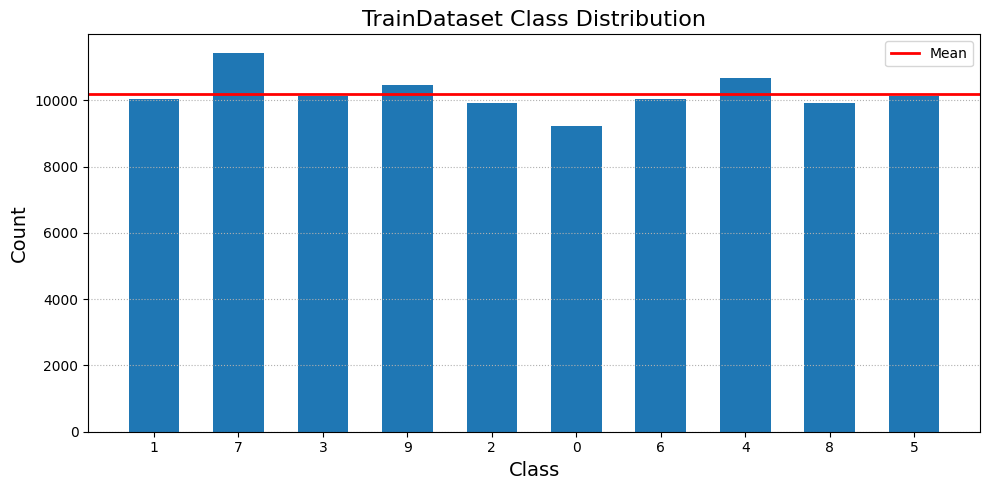

In [4]:
# Посмотрим на распределение данных

labels = train_dataset.label.value_counts().index # Получаем названия классов
counts = train_dataset.label.value_counts() # Получаем количество строк по классам

plt.figure(figsize=(10, 5))
plt.bar(labels, counts, width=0.6)
plt.xticks(np.arange(len(labels)), labels)
plt.xlabel('Class', fontsize=14) # Добавляем текст на ось X
plt.ylabel('Count', fontsize=14) # Добавляем текст на ось Y
plt.title('TrainDataset Class Distribution', fontsize=16) # Добавляем заголовок об распределение классов

# Добавляем линию, чтобы показать равномерность распределения признаков
plt.axhline(counts.mean(), color='red', linewidth=2, label='Mean')
plt.legend()
plt.grid(axis='y', linestyle='dotted')
plt.tight_layout()
plt.show()

In [5]:
'''
1. В объединённом тренировочном датасете 102000 записей и 785 признаков. 
2. Отсутствуют пропущенные данные.
3. Признаки для классификации одинаковые для тренировочных и тестовых данных.
4. Все классы распределены +- равномерно. Больше всего - "7" и меньше всего - "0".
'''

# 2. Предобработка данных.

# Выделяем данные для обучения (без первого столбца с ответами)
x_train = train_dataset.drop('label', axis=1) # Оставляем чисто изображение
x_train = np.array(x_train)
x_test = test_mnist.drop('label', axis=1)
x_test = np.array(x_test)

# Выделяем правильные ответы
y_train = train_dataset['label']
print('\nПравильные ответы:\n', y_train)
y_train = np.array(y_train)

y_test = test_mnist['label']
y_test = np.array(y_test)


Правильные ответы:
 0         1
1         0
2         1
3         4
4         0
         ..
101995    8
101996    3
101997    5
101998    6
101999    8
Name: label, Length: 102000, dtype: int64


In [6]:
'''
 Ответы не разделены на 10 различных меток классов, а представлены в виде одного массива
со значениями классов. Преобразуем ответы в формат one hot encoding.
'''
y_train = np.eye(10)[y_train]
print('\nПравильные ответы в формате one hot encoding:\n', y_train[:4])
y_test = np.eye(10)[y_test]


Правильные ответы в формате one hot encoding:
 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


(102000, 28, 28, 1)


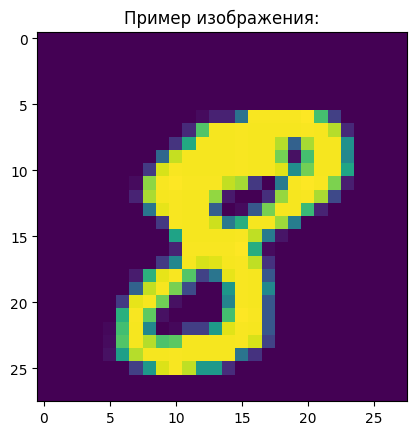

In [7]:
'''
Наши изображения имеют глубину 1, но мы должны явно объявить это.
Другими словами, преобразуем наш набор данных из формы (n, ширина, высота) в (n, ширина, высота, глубина).
'''
# Изменяем размер данных обучающей и тестовой выборок (28x28x1)
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
print(x_train.shape)

plt.imshow(x_train[10])
plt.title("Пример изображения:")
plt.show()

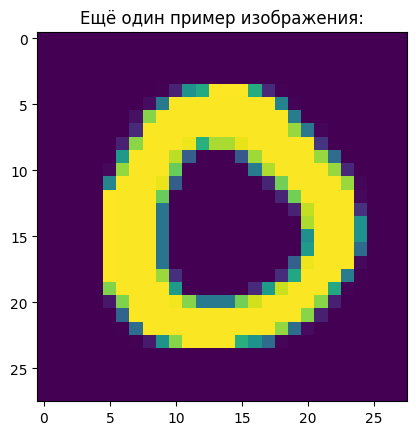

In [8]:
plt.imshow(x_train[4])
plt.title("Ещё один пример изображения:")
plt.show()

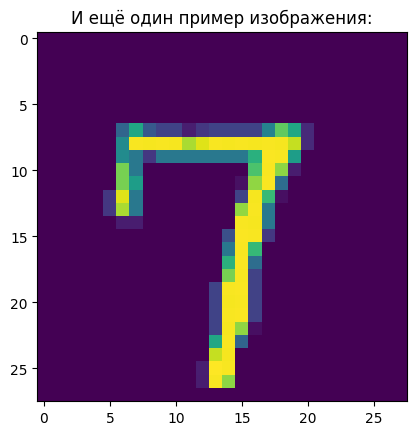

In [9]:
plt.imshow(x_train[6])
plt.title("И ещё один пример изображения:")
plt.show()

In [10]:
# Нормализация данных для обучения и тестирования
x_train = x_train.astype('float32')
x_train /= 255.0
x_test = x_test.astype('float32')
x_test /= 255.0

print('\nДанные готовы к построению модели.')


Данные готовы к построению модели.


In [11]:
model = models.Sequential()

'''
Укажем какие слои будут присутствовать в нашей нейронной сети.
Sequential() задаёт линейное (или «последовательное») расположение слоев.
'''
model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)))
# Этот слой создает ядро свертки, которое свертывается со входом слоя для получения тензора выходов.

model.add(layers.MaxPooling2D((2,2)))
# Операция максимальной подвыборки (субдискретизации) для пространственных данных. Используется для уменьшения размерности
# изображения с целью улучшения производительности сети. Обычно выбирается максимальное (или среднее) значение из некоторой области изображения. 

model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.Flatten())
# Используется для преобразования двухмерного массива признаков в одномерный массив, который может быть входом для полносвязной нейронной сети. 

model.add(layers.Dense(64,activation='relu'))
# Это основной слой для любой нейронной сети. Он применяется для полносвязного соединения всех входных данных с выходным слоем. Его главная функция
# – изменение размерности данных, чтобы они могли быть переданы на следующий слой сети.

model.add(layers.Dense(10,activation='softmax'))
# Зададим метод тренировки

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
'''
Функция model.compile() вызывается по заранее построенной модели и определяет функцию потерь, оптимизатор и метрики.

Оптимизатор «Адам» является широко используемым оптимизатором и прекрасно работает для задач классификации.

Используем функцию потерь для обучения - CategoricalCrossentropy, которая принимает вектор логитов
и индекс True и возвращает скалярную потерю для каждого примера. Эта ф-ция хороша для задач классификации мультикласса,
подобно нашей.

Последняя часть model.compile() - указывает метрики, которые она должна использовать при оценке модели.
'''
# Обучаем нашу модель
history = model.fit(x_train, y_train, epochs=8, batch_size=64, validation_split=0.2)

Epoch 1/8


2023-12-13 02:15:40.351067: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 255897600 exceeds 10% of free system memory.


1275/1275 [==============================] - 99s 76ms/step - loss: 0.1494 - accuracy: 0.9535 - val_loss: 0.0540 - val_accuracy: 0.9832
Epoch 2/8
1275/1275 [==============================] - 96s 75ms/step - loss: 0.0404 - accuracy: 0.9876 - val_loss: 0.0385 - val_accuracy: 0.9878
Epoch 3/8
1275/1275 [==============================] - 95s 74ms/step - loss: 0.0277 - accuracy: 0.9907 - val_loss: 0.0290 - val_accuracy: 0.9905
Epoch 4/8
1275/1275 [==============================] - 95s 74ms/step - loss: 0.0208 - accuracy: 0.9930 - val_loss: 0.0262 - val_accuracy: 0.9921
Epoch 5/8
1275/1275 [==============================] - 95s 74ms/step - loss: 0.0159 - accuracy: 0.9947 - val_loss: 0.0237 - val_accuracy: 0.9928
Epoch 6/8
1275/1275 [==============================] - 95s 75ms/step - loss: 0.0135 - accuracy: 0.9954 - val_loss: 0.0226 - val_accuracy: 0.9939
Epoch 7/8
1275/1275 [==============================] - 94s 74ms/step - loss: 0.0102 - accuracy: 0.9965 - val_loss: 0.0270 - val_accuracy: 0.

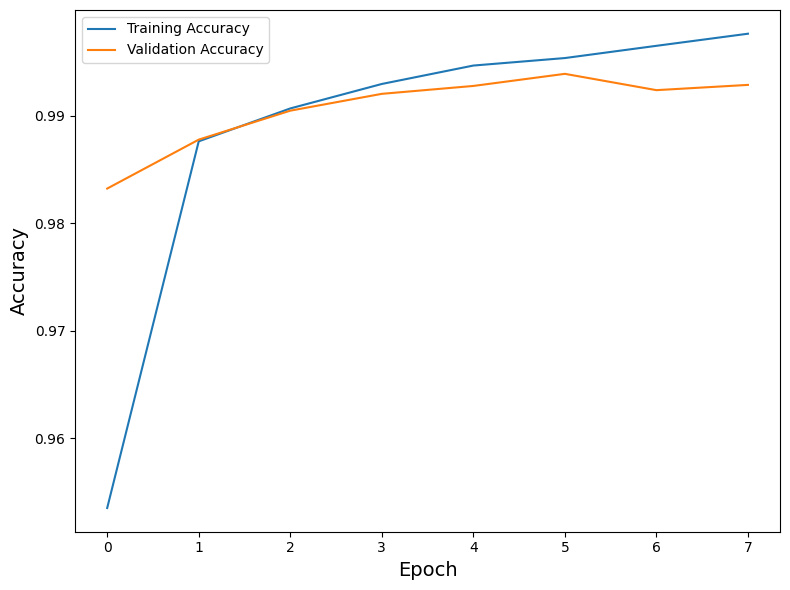

In [12]:
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

plt.xlabel('Epoch', fontsize=14) # Добавляем текст на ось X
plt.ylabel('Accuracy', fontsize=14) # Добавляем текст на ось Y

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()

plt.tight_layout()
plt.show()

In [13]:
print('x_test', x_test.shape)
print('y_test', y_test.shape)
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Точность на тестовых данных: ", test_acc)
print("Потери на тестовых данных: ", test_loss)

x_test (10000, 28, 28, 1)
y_test (10000, 10)
313/313 [==============================] - 4s 12ms/step - loss: 0.0214 - accuracy: 0.9943
Точность на тестовых данных:  0.9943000078201294
Потери на тестовых данных:  0.021396802738308907


In [18]:
image_index = 2

image = x_test[image_index]

image = np.expand_dims(image, axis=0)

predictions = model.predict(image)
print(predictions)

predicted_class = np.argmax(predictions)
trust_class = np.argmax(y_test[image_index])

print("Предсказанный класс: ", predicted_class)
print("Настоящий класс: ", trust_class)

1/1 [==============================] - 0s 25ms/step
[[1.8039640e-12 1.0000000e+00 2.1986724e-14 7.5707527e-14 5.9084365e-10
  1.6246919e-13 2.8629670e-12 1.7431134e-09 2.4455500e-11 1.3672754e-12]]
Предсказанный класс:  1
Настоящий класс:  1


In [19]:
# Поменяем batch_size
history = model.fit(x_train, y_train, epochs=8, batch_size=32, validation_split=0.2)

Epoch 1/8


2023-12-13 02:39:33.442344: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 255897600 exceeds 10% of free system memory.


2550/2550 [==============================] - 101s 39ms/step - loss: 0.0163 - accuracy: 0.9946 - val_loss: 0.0239 - val_accuracy: 0.9931
Epoch 2/8
2550/2550 [==============================] - 100s 39ms/step - loss: 0.0110 - accuracy: 0.9964 - val_loss: 0.0248 - val_accuracy: 0.9930
Epoch 3/8
2550/2550 [==============================] - 100s 39ms/step - loss: 0.0090 - accuracy: 0.9971 - val_loss: 0.0221 - val_accuracy: 0.9942
Epoch 4/8
2550/2550 [==============================] - 100s 39ms/step - loss: 0.0083 - accuracy: 0.9974 - val_loss: 0.0236 - val_accuracy: 0.9942
Epoch 5/8
2550/2550 [==============================] - 100s 39ms/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0.0207 - val_accuracy: 0.9953
Epoch 6/8
2550/2550 [==============================] - 99s 39ms/step - loss: 0.0064 - accuracy: 0.9979 - val_loss: 0.0256 - val_accuracy: 0.9937
Epoch 7/8
2550/2550 [==============================] - 99s 39ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0288 - val_accurac

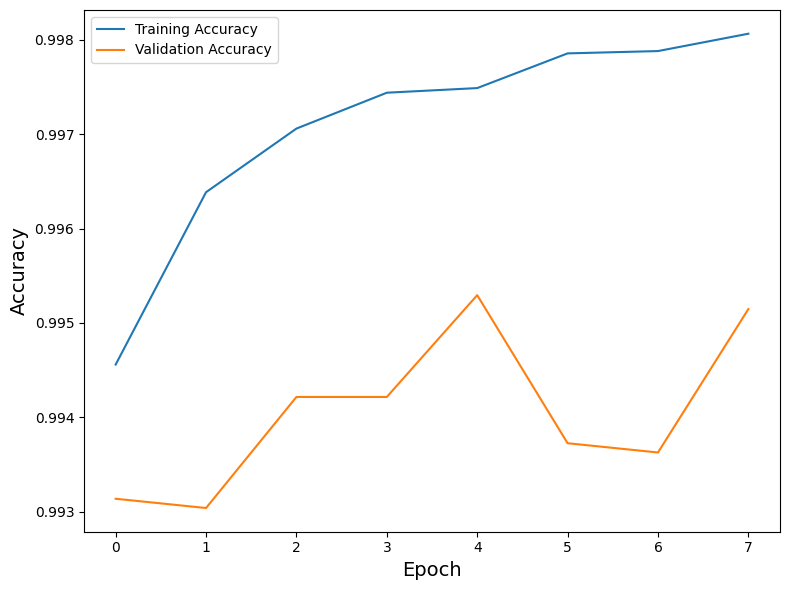

In [20]:
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

plt.xlabel('Epoch', fontsize=14) # Добавляем текст на ось X
plt.ylabel('Accuracy', fontsize=14) # Добавляем текст на ось Y

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()

plt.tight_layout()
plt.show()

In [21]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Точность на тестовых данных: ", test_acc)
print("Потери на тестовых данных: ", test_loss)

313/313 [==============================] - 4s 12ms/step - loss: 0.0179 - accuracy: 0.9965
Точность на тестовых данных:  0.9965000152587891
Потери на тестовых данных:  0.017883721739053726


In [22]:
history = model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.2)

Epoch 1/5
   1/1275 [..............................] - ETA: 1:35 - loss: 1.6575e-04 - accuracy: 1.0000

2023-12-13 02:59:31.980236: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 255897600 exceeds 10% of free system memory.


1275/1275 [==============================] - 94s 74ms/step - loss: 0.0012 - accuracy: 0.9996 - val_loss: 0.0164 - val_accuracy: 0.9968
Epoch 2/5
1275/1275 [==============================] - 93s 73ms/step - loss: 2.2973e-04 - accuracy: 0.9999 - val_loss: 0.0180 - val_accuracy: 0.9965
Epoch 3/5
1275/1275 [==============================] - 93s 73ms/step - loss: 0.0034 - accuracy: 0.9991 - val_loss: 0.0202 - val_accuracy: 0.9956
Epoch 4/5
1275/1275 [==============================] - 94s 74ms/step - loss: 0.0037 - accuracy: 0.9988 - val_loss: 0.0290 - val_accuracy: 0.9948
Epoch 5/5
1275/1275 [==============================] - 93s 73ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.0317 - val_accuracy: 0.9943


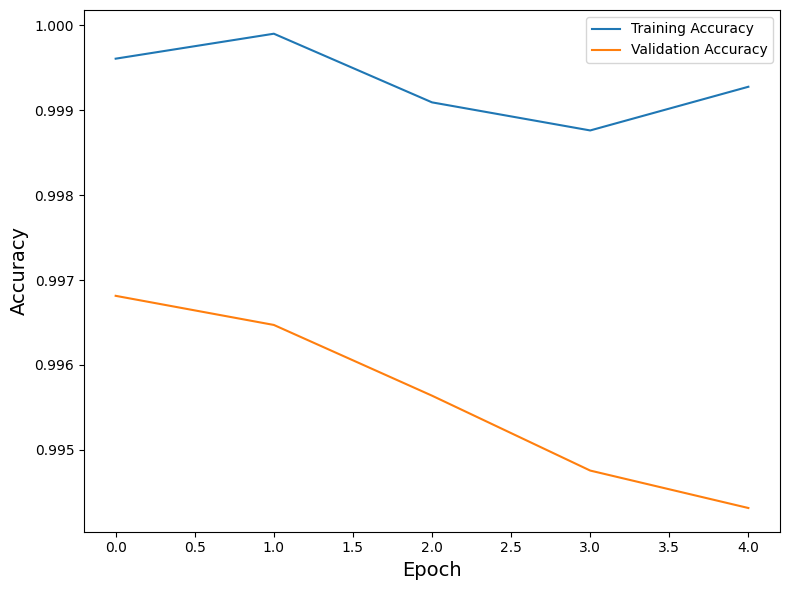

In [23]:
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

plt.xlabel('Epoch', fontsize=14) # Добавляем текст на ось X
plt.ylabel('Accuracy', fontsize=14) # Добавляем текст на ось Y

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()

plt.tight_layout()
plt.show()

In [24]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Точность на тестовых данных: ", test_acc)
print("Потери на тестовых данных: ", test_loss)

313/313 [==============================] - 4s 12ms/step - loss: 0.0218 - accuracy: 0.9964
Точность на тестовых данных:  0.996399998664856
Потери на тестовых данных:  0.02183954231441021


In [25]:
history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
   1/2550 [..............................] - ETA: 2:14 - loss: 2.8758e-06 - accuracy: 1.0000

2023-12-13 03:10:53.039901: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 255897600 exceeds 10% of free system memory.


2550/2550 [==============================] - 101s 40ms/step - loss: 0.0067 - accuracy: 0.9981 - val_loss: 0.0348 - val_accuracy: 0.9931
Epoch 2/5
2550/2550 [==============================] - 98s 39ms/step - loss: 0.0047 - accuracy: 0.9987 - val_loss: 0.0237 - val_accuracy: 0.9952
Epoch 3/5
2550/2550 [==============================] - 98s 39ms/step - loss: 0.0042 - accuracy: 0.9987 - val_loss: 0.0218 - val_accuracy: 0.9955
Epoch 4/5
2550/2550 [==============================] - 98s 38ms/step - loss: 0.0044 - accuracy: 0.9987 - val_loss: 0.0271 - val_accuracy: 0.9951
Epoch 5/5
2550/2550 [==============================] - 99s 39ms/step - loss: 0.0048 - accuracy: 0.9985 - val_loss: 0.0251 - val_accuracy: 0.9954


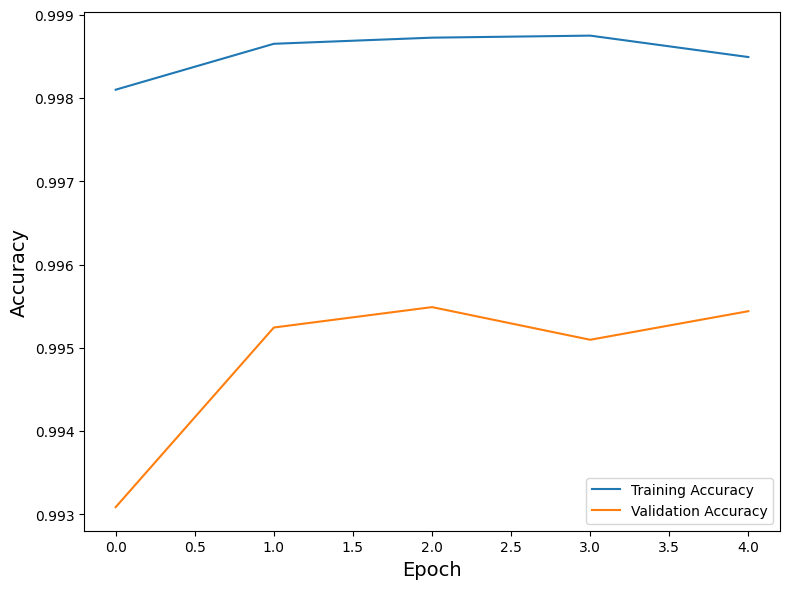

In [26]:
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

plt.xlabel('Epoch', fontsize=14) # Добавляем текст на ось X
plt.ylabel('Accuracy', fontsize=14) # Добавляем текст на ось Y

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()

plt.tight_layout()
plt.show()

In [27]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Точность на тестовых данных: ", test_acc)
print("Потери на тестовых данных: ", test_loss)

313/313 [==============================] - 4s 14ms/step - loss: 0.0222 - accuracy: 0.9961
Точность на тестовых данных:  0.9961000084877014
Потери на тестовых данных:  0.022156652063131332


In [28]:
# Попробуем добавить ещё один полносвязный слой

model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5


2023-12-13 03:29:23.027210: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 255897600 exceeds 10% of free system memory.


2550/2550 [==============================] - 105s 41ms/step - loss: 0.1326 - accuracy: 0.9581 - val_loss: 0.0623 - val_accuracy: 0.9808
Epoch 2/5
2550/2550 [==============================] - 101s 40ms/step - loss: 0.0392 - accuracy: 0.9876 - val_loss: 0.0342 - val_accuracy: 0.9895
Epoch 3/5
2550/2550 [==============================] - 100s 39ms/step - loss: 0.0273 - accuracy: 0.9914 - val_loss: 0.0322 - val_accuracy: 0.9904
Epoch 4/5
2550/2550 [==============================] - 100s 39ms/step - loss: 0.0206 - accuracy: 0.9936 - val_loss: 0.0335 - val_accuracy: 0.9910
Epoch 5/5
2550/2550 [==============================] - 99s 39ms/step - loss: 0.0163 - accuracy: 0.9951 - val_loss: 0.0288 - val_accuracy: 0.9923


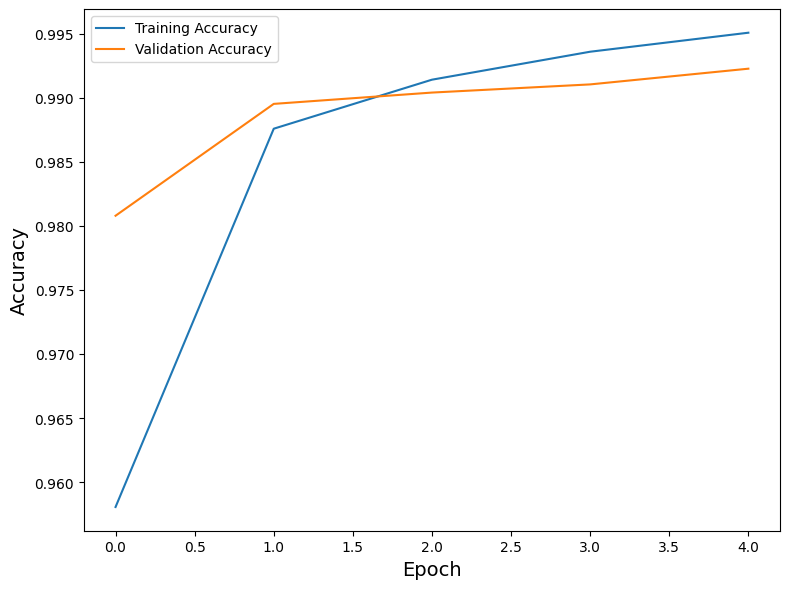

In [29]:
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

plt.xlabel('Epoch', fontsize=14) # Добавляем текст на ось X
plt.ylabel('Accuracy', fontsize=14) # Добавляем текст на ось Y

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()

plt.tight_layout()
plt.show()

In [30]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Точность на тестовых данных: ", test_acc)
print("Потери на тестовых данных: ", test_loss)

313/313 [==============================] - 4s 11ms/step - loss: 0.0173 - accuracy: 0.9940
Точность на тестовых данных:  0.9940000176429749
Потери на тестовых данных:  0.017332730814814568


In [32]:
# Попробуем добавить ещё один полносвязный слой на вход

model = models.Sequential()

model.add(layers.Dense(64,activation='relu', input_shape=(28,28,1)))
model.add(layers.Conv2D(32,(3,3), activation='relu' ))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.Flatten())

model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(10,activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
2550/2550 [==============================] - 407s 159ms/step - loss: 0.1113 - accuracy: 0.9649 - val_loss: 0.0509 - val_accuracy: 0.9840
Epoch 2/5
2550/2550 [==============================] - 408s 160ms/step - loss: 0.0358 - accuracy: 0.9892 - val_loss: 0.0415 - val_accuracy: 0.9869
Epoch 3/5
2550/2550 [==============================] - 407s 159ms/step - loss: 0.0241 - accuracy: 0.9926 - val_loss: 0.0618 - val_accuracy: 0.9809
Epoch 4/5
2550/2550 [==============================] - 403s 158ms/step - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.0242 - val_accuracy: 0.9926
Epoch 5/5
2550/2550 [==============================] - 402s 157ms/step - loss: 0.0133 - accuracy: 0.9956 - val_loss: 0.0197 - val_accuracy: 0.9940


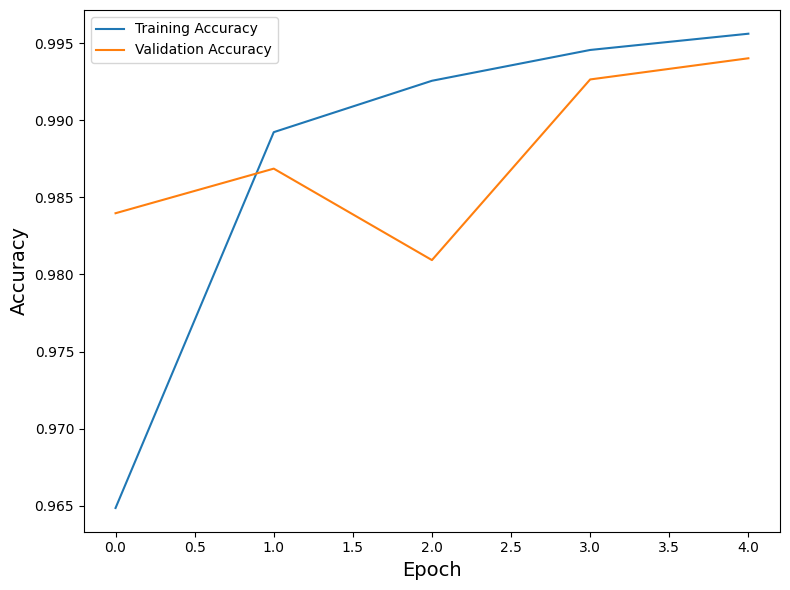

In [33]:
model_history = pd.DataFrame(history.history)
model_history['epoch'] = history.epoch

fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

plt.xlabel('Epoch', fontsize=14) # Добавляем текст на ось X
plt.ylabel('Accuracy', fontsize=14) # Добавляем текст на ось Y

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()

plt.tight_layout()
plt.show()

In [34]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Точность на тестовых данных: ", test_acc)
print("Потери на тестовых данных: ", test_loss)

313/313 [==============================] - 12s 39ms/step - loss: 0.0166 - accuracy: 0.9943
Точность на тестовых данных:  0.9943000078201294
Потери на тестовых данных:  0.01660703308880329
